In [1]:
import os
import urllib
import librosa
import numpy as np
from funcs import *
import pandas as pd
import regex
from string import punctuation
from python_speech_features import mfcc, logfbank

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## EDA

In [2]:
song_df = pd.read_csv('./data/song_genres.csv')

In [3]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132491 entries, 0 to 132490
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                132491 non-null  object
 1   genre             132491 non-null  object
 2   track_name        132491 non-null  object
 3   preview_url       76680 non-null   object
 4   location          132491 non-null  object
 5   filename          132491 non-null  object
 6   artist            132491 non-null  object
 7   artist_uri        132491 non-null  object
 8   album             132491 non-null  object
 9   release_date      132491 non-null  object
 10  danceability      132491 non-null  object
 11  energy            132491 non-null  object
 12  key               132491 non-null  object
 13  loudness          132491 non-null  object
 14  mode              132491 non-null  object
 15  speechiness       132491 non-null  object
 16  acousticness      132491 non-null  obj

In [4]:
#We only want songs that have preview urls
song_df = song_df.copy()[song_df['preview_url'].notnull()]

In [5]:
# There are some residual headers left over from when we stored our csvs. Let's remove them.
song_df = song_df.copy()[song_df['track_name'] != 'track_name']

In [6]:
# The same song may have been in multiple playlists, so let's get rid of those
song_df.drop_duplicates(inplace=True)

In [7]:
song_df['track_name'].unique().shape[0]

9365

We've collected **9365 unique songs**, I want to have at least 500 in each genre I'm looking at. Let's see which genres have at least 500 songs in our dataset

In [8]:
genre_over_500 = song_df['genre'].value_counts() >= 500

In [9]:
song_df['genre'].value_counts()[genre_over_500]

classical                            3013
classical performance                1867
early music                          1495
baroque                              1334
pop                                  1163
rap                                  1067
dance pop                             985
tropical house                        952
pop rap                               933
serialism                             920
avant-garde                           818
r&b                                   735
trap                                  699
urban contemporary                    687
german baroque                        678
orchestral performance                673
contemporary classical                632
early modern classical                617
historically informed performance     607
edm                                   598
hip hop                               589
progressive bluegrass                 585
rock                                  582
italian baroque                   

I want to add more genres that are closely related this time around, to see if the classifier performs worse:
* classical
* baroque
* serialism
* rap
* r&b
* hip hop
* rock
* progressive bluegrass
* tropical house
* pop


In [10]:
genre_list = [
    'classical',
    'baroque',
    'serialism',
    'rap',
    'r&b',
    'hip hop',
    'rock',
    'progressive bluegrass',
    'tropical house',
    'pop'
]

In [11]:
song_df_10_genres = song_df[song_df['genre'].isin(genre_list)]

The same song can be in multiple genres, so let's make sure we only keep songs that are in one genre or the other.

In [12]:
song_df_10_genres.drop_duplicates(subset=['id'])['genre'].value_counts()

baroque                  1298
classical                1220
pop                       785
rock                      570
tropical house            535
progressive bluegrass     524
serialism                 418
hip hop                   343
rap                       312
r&b                       146
Name: genre, dtype: int64

That has severely reduced the amount of songs I have per genre (probably a sign that certain genres are going to be difficult for the model to discern between). Hip hop, Rap, and R&B seemed to have the largest drop in tracks after removing duplicates.

Because the classes are unequal, I'm going to **bootstrap the samples in order to get 500 of each genre.**

In [15]:
size = 500        # sample size
np.random.seed(182)
pick_samples = lambda x: x.sample(size, replace=True) # without replacement by default

# Thanks Zero from stack overflow for this: https://stackoverflow.com/questions/22472213/python-random-selection-per-group
songs_sampled_500 = song_df_10_genres.groupby('genre', as_index=False).apply(pick_samples).reset_index(drop=True)

In [16]:
# Let's save this to a .csv
songs_sampled_500.to_csv('./data/ten_genres_500_samp.csv', index=False)

In [17]:
songs_sampled_500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                5000 non-null   object
 1   genre             5000 non-null   object
 2   track_name        5000 non-null   object
 3   preview_url       5000 non-null   object
 4   location          5000 non-null   object
 5   filename          5000 non-null   object
 6   artist            5000 non-null   object
 7   artist_uri        5000 non-null   object
 8   album             5000 non-null   object
 9   release_date      5000 non-null   object
 10  danceability      5000 non-null   object
 11  energy            5000 non-null   object
 12  key               5000 non-null   object
 13  loudness          5000 non-null   object
 14  mode              5000 non-null   object
 15  speechiness       5000 non-null   object
 16  acousticness      5000 non-null   object
 17  instrumentalne

In [18]:
songs_sampled_500['genre'].value_counts()

progressive bluegrass    500
rap                      500
rock                     500
tropical house           500
serialism                500
r&b                      500
baroque                  500
classical                500
pop                      500
hip hop                  500
Name: genre, dtype: int64

In [19]:
genres = list(songs_sampled_500['genre'].unique())

In [20]:
# Now let's get the 30-second song sample into something we can use
for i in range(songs_sampled_500.shape[0]):
    # We need to get the preview url, genre, and track name for file naming
    url = songs_sampled_500.loc[i, "preview_url"]
    genre = songs_sampled_500.loc[i, "genre"]
    track_name = songs_sampled_500.loc[i, "track_name"]
    
    # People put a lot of symbols in their songs (esp. classical music), so we need to clean those
    track_name = ' '.join(regex.findall('[A-Za-z0-9]+', track_name))
    
    # Let's open the mp3 file and make folders
    mp3file = urllib.request.urlopen(url)
    os.makedirs(f'./scrapes/{genre}', exist_ok=True)

    # Let's write this song to a folder! Adding z-filled numbers to counter songs with the same title being overwritten
    with open(f'./scrapes/{genre}/{str(i).zfill(4)}_{track_name.strip(punctuation)}.mp3','wb') as output:
          output.write(mp3file.read())

In [21]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for g in genres:
    g_df = songs_sampled_500[songs_sampled_500['genre'] == g].head(2) # Create a dataframe for the class
    for i in range(2):
        track_name = g_df.loc[g_df.index[i], "track_name"]
        track_name = ' '.join(regex.findall('[A-Za-z0-9]+', track_name))
        signal, rate = librosa.load(f'./scrapes/{g}/{str(g_df.index[i]).zfill(4)}_{track_name.strip(punctuation)}.mp3') # Get the signal and rate from each file
        mask = envelope(signal, rate, 0.0005)
        signal = signal[mask] # Cutting out the silences at the beginning and end (if any)
        signals[f'{g}_{i + 1}'] = signal
        fft[f'{g}_{i + 1}'] = calc_fft(signal, rate)
        bank = logfbank(signal[:rate], 
                        rate, 
                        nfilt=26, 
                        nfft=1103).T
        fbank[f'{g}_{i + 1}'] = bank
        mfccs[f'{g}_{i + 1}'] = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=round(int(44100) / 40)).T
        print(f'Finished with folder {g}_{i + 1}, moving on!')

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder baroque_1, moving on!


C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder baroque_2, moving on!
Finished with folder classical_1, moving on!
Finished with folder classical_2, moving on!
Finished with folder hip hop_1, moving on!
Finished with folder hip hop_2, moving on!
Finished with folder pop_1, moving on!
Finished with folder pop_2, moving on!
Finished with folder progressive bluegrass_1, moving on!
Finished with folder progressive bluegrass_2, moving on!
Finished with folder r&b_1, moving on!
Finished with folder r&b_2, moving on!
Finished with folder rap_1, moving on!
Finished with folder rap_2, moving on!
Finished with folder rock_1, moving on!
Finished with folder rock_2, moving on!
Finished with folder serialism_1, moving on!
Finished with folder serialism_2, moving on!
Finished with folder tropical house_1, moving on!
Finished with folder tropical house_2, moving on!


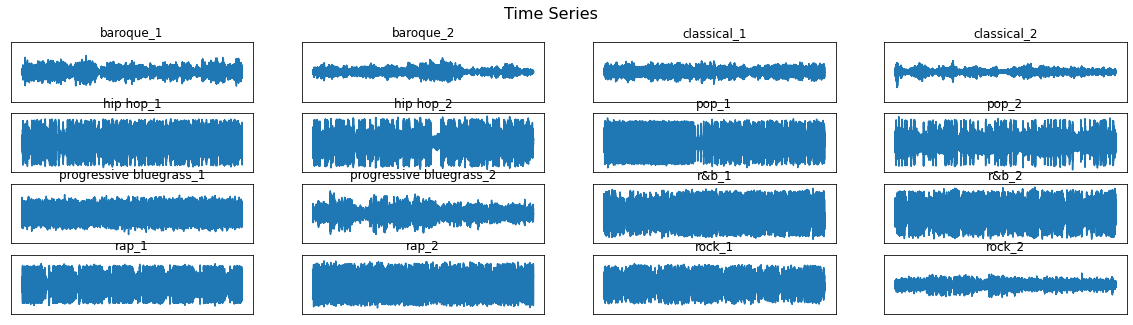

In [22]:
plot_signals(signals);

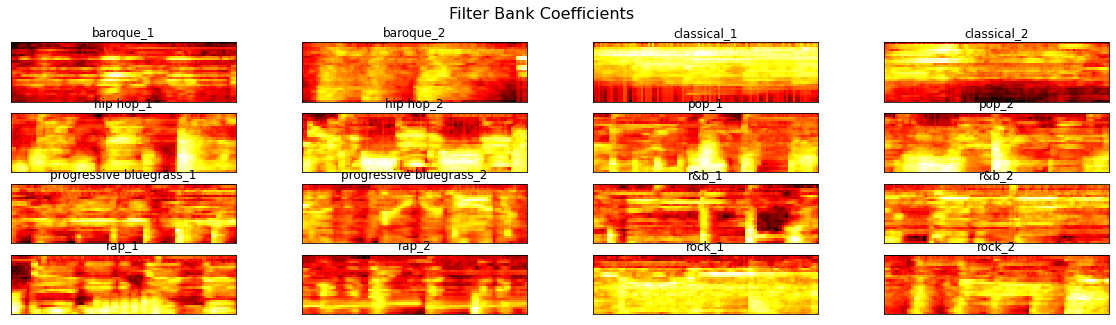

In [23]:
plot_fbank(fbank, signals);

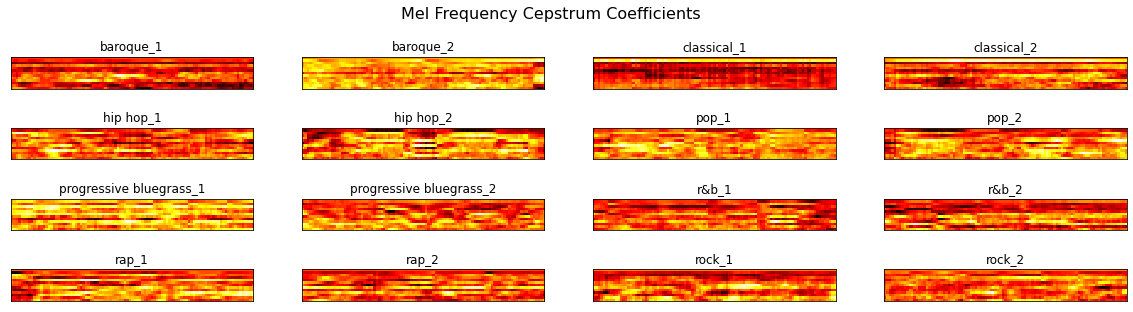

In [24]:
plot_mfccs(mfccs, signals);

### Insights

Right now, this is very basic EDA that I am borrowing from [Seth Adams's video](https://www.youtube.com/watch?v=Z7YM-HAz-IY&list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P), and many of these graphs are the same song. What I'll need to do next is scrape many different genre-based playlists until I can identify 5-10 genres that seem to be the most popular.

Even with this limited EDA, the Mel Frequency Cepstrum Coefficients for songs do look different, and if there are common traits between songs within genres, I will be able to classify them.